In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
!pip install bigartm10

In [ ]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import numpy as np
import artm

from tqdm import trange

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def print_measures(model_plsa):
    print('Sparsity Phi: {0:.3f} (PLSA)'.format(
        model_plsa.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f} (PLSA)'.format(
        model_plsa.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (PLSA)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (PLSA)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (PLSA)'.format(
        model_plsa.score_tracker['PerplexityScore'].last_value))

In [ ]:
def print_scores(scores, save=None, many=False):
    print_measures(model_plsa)
    plt.figure()
    phi, theta = None, None
    if many:
        for scores_dict in scores:
            phi, = plt.plot(scores_dict['SparsityPhiScore'], 'r--', linewidth=2, alpha=0.3)
            theta, = plt.plot(scores_dict['SparsityThetaScore'], 'b--', linewidth=2, alpha=0.3)
    else:
        phi, = plt.plot(scores['SparsityPhiScore'].value, 'r--', linewidth=2)
        theta, = plt.plot(scores['SparsityThetaScore'].value, 'b--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('Sparsity')
    plt.legend([phi, theta], ['Phi sparsity', 'Theta sparsity'])
    plt.grid(True)
    if save:
        plt.savefig(save+"_sparsity.eps", format='pdf', dpi=1000,
                    bbox_inches='tight', pad_inches=0)
    plt.show()

    plt.figure()
    contrast, purity = None, None
    if many:
        for scores_dict in scores:
            contrast, = plt.plot(scores_dict['TopicKernelScore'].average_contrast, 'r', linewidth=2, alpha=0.3)
            purity, = plt.plot(scores_dict['TopicKernelScore'].average_purity, 'b', linewidth=2, alpha=0.3)
    else:
        contrast, = plt.plot(scores['TopicKernelScore'].average_contrast, 'r', linewidth=2)
        purity, = plt.plot(scores['TopicKernelScore'].average_purity, 'b', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('Contrast/Purity')
    plt.grid(True)
    plt.legend([contrast, purity], ['Average contrast', 'Average purity'])
    if save:
        plt.savefig(save+"_contrast_purity.eps", format='pdf', dpi=1000,
                    bbox_inches='tight', pad_inches=0)
    plt.show()

    plt.figure()
    perp = None
    if many:
        for scores_dict in scores:
            perp, = plt.plot(scores_dict['PerplexityScore'].value, 'b--', linewidth=2, alpha=0.3)
    else:
        perp, = plt.plot(scores['PerplexityScore'].value, 'b--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('Perplexity')
    plt.xlim(1)
    plt.legend([perp], ['Model perplexity'])
    plt.grid(True)
    if save:
        plt.savefig(save+"_perplexity.eps", format='pdf', dpi=1000,
                    bbox_inches='tight', pad_inches=0)
    plt.show()

In [ ]:
batch_vectorizer = None
if len(glob.glob(os.path.join('batches', '*.batch'))) < 1:
  batch_vectorizer = artm.BatchVectorizer(data_path='lenta', data_format='bow_uci',
                                                collection_name='lenta', target_folder='batches')
else:
  batch_vectorizer = artm.BatchVectorizer(data_path='batches', data_format='batches')

In [ ]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='batches')
dictionary.save(dictionary_path='batches/dictionary')


dictionary.load(dictionary_path='batches/dictionary.dict')

In [ ]:
parameters = {
    'num_topics': 100,
    'num_collection_passes': 20,
    'num_document_passes': 1
}

num_topics = parameters['num_topics']
num_collection_passes = parameters['num_collection_passes']
num_document_passes = parameters['num_document_passes']

topic_names = ['@topic_'+str(i) for i in range(num_topics)]

In [ ]:
model_plsa = artm.ARTM(topic_names=topic_names, cache_theta=True)

model_plsa.initialize(dictionary=dictionary)

tokens_class = "@default_class"
model_plsa.class_ids = {tokens_class: 1.0}

model_plsa.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                               dictionary=dictionary))
model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.3))
#model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=15))

In [ ]:
model_plsa.num_document_passes = num_document_passes

model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [ ]:
model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=15))

model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

In [ ]:
for topic_name in model_plsa.topic_names:
    print(topic_name + ': ')
    print(model_plsa.score_tracker['TopTokensScore'].last_tokens[topic_name])

@topic_0: 
['исследование', 'ученый', 'организм', 'клетка', 'болезнь', 'заболевание', 'риск', 'врач', 'страдать', 'опасный', 'мозг', 'кровь', 'специалист', 'боль', 'доктор']
@topic_1: 
['президент', 'владимир', 'путин', 'лидер', 'глава', 'государство', 'зеленский', 'указ', 'экс', 'телефонный', 'ход', 'саммит', 'кремль', 'встреча', 'состояться']
@topic_2: 
['продукт', 'магазин', 'товар', 'продукция', 'килограмм', 'ресторан', 'питание', 'посоветовать', 'вес', 'хозяйство', 'еда', 'мясо', 'сельский', 'производитель', 'правильный']
@topic_3: 
['нато', 'церковь', 'альянс', 'общество', 'вступление', 'швеция', 'финляндия', 'храм', 'православный', 'религиозный', 'кирилл', 'эстония', 'ценность', 'святой', 'член']
@topic_4: 
['миллиард', 'фонд', 'бюджет', 'правительство', 'увеличивать', 'средство', 'налог', 'выделять', 'долг', 'расход', 'доход', 'триллион', 'повышение', 'условие', 'финансирование']
@topic_5: 
['источник', 'ссылка', 'сообщать', 'база', 'техника', 'передавать', 'технический', 'верт

Sparsity Phi: 0.878 (PLSA)
Sparsity Theta: 0.000 (PLSA)
Kernel contrast: 0.814 (PLSA)
Kernel purity: 0.745 (PLSA)
Perplexity: 1848.700 (PLSA)


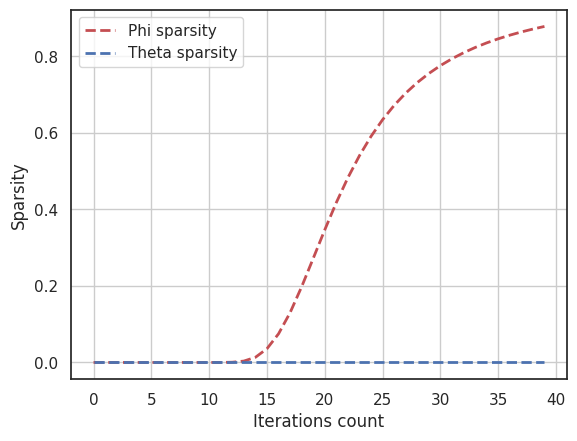

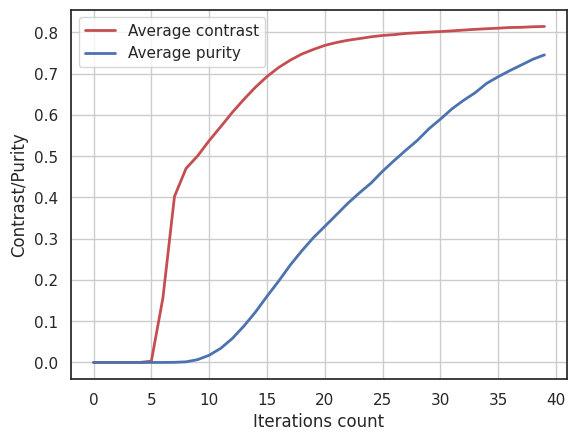

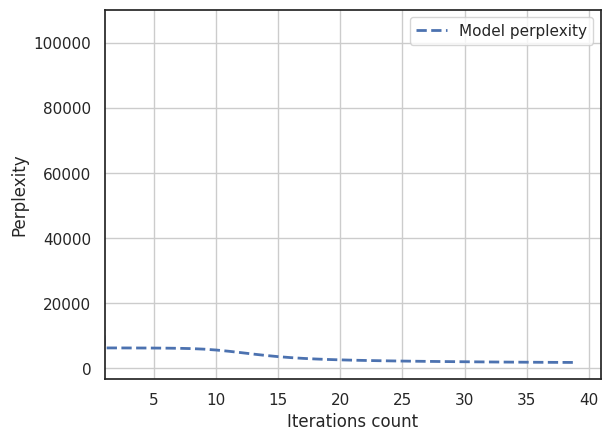

In [ ]:
print_scores(model_plsa.score_tracker, save='PLSA', many=False)

In [ ]:
phi = model_plsa.get_phi(class_ids=[tokens_class]).values

In [ ]:
def get_corr_matrix(phi):
    df = pd.DataFrame(phi)
    return df.corr()

corr_matrix = get_corr_matrix(phi).values

In [ ]:
def plot_corr_matrix(matrix, save=None):
    sns.set(style="white")
    f, ax = plt.subplots(figsize=(20, 10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(matrix, cmap='Greens', vmin=0.0,
            square=True, xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    ax.set_title('Topic-topic correlation matrix')
    if save:
        plt.savefig(save, format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)

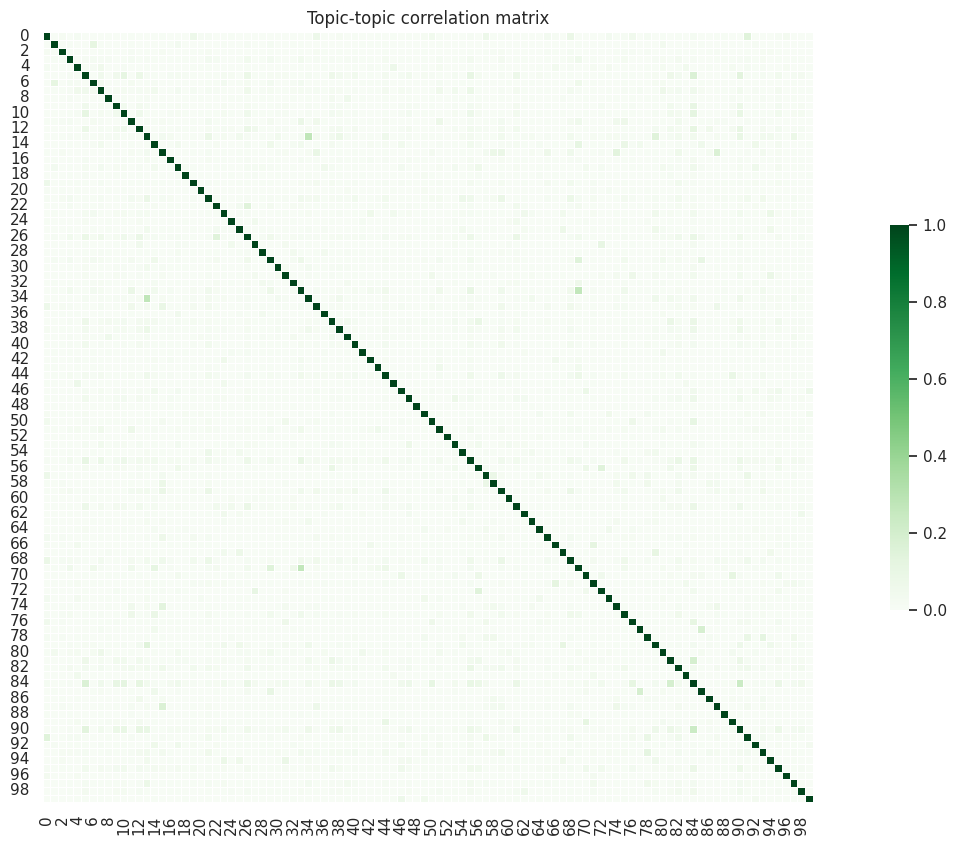

In [ ]:
plot_corr_matrix(corr_matrix, save='PLSA_corr.eps')

In [ ]:
theta = model_plsa.get_theta().values
phi = model_plsa.get_phi().values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def plot_matrix(matrix, figsize=(20,15), xlabel='', ylabel='', title='', save=None):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.binary)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    if save:
        plt.savefig(save, format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)
    print(np.any(np.isnan(matrix)))

<>:2: DeprecationWarning: invalid escape sequence '\T'


False


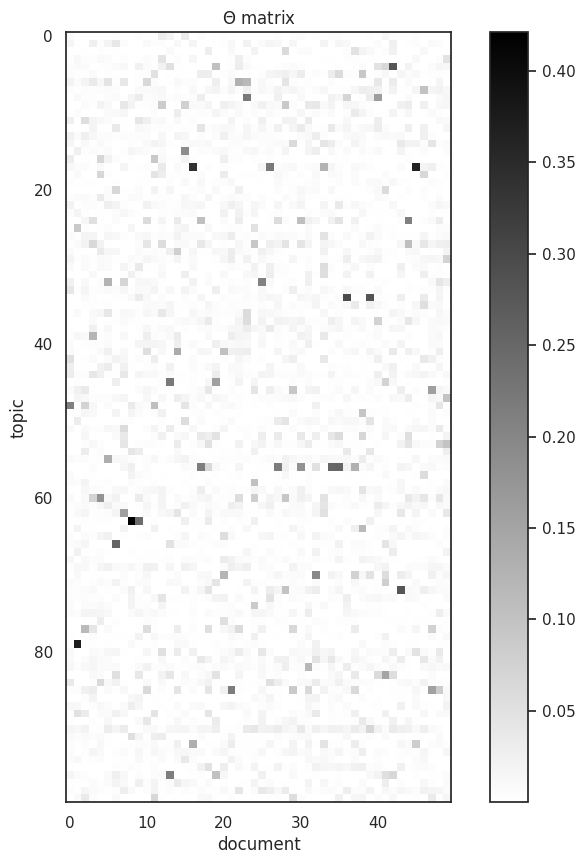

In [ ]:
plot_matrix(theta[:,:50], figsize=(10,10), xlabel='document', ylabel='topic',
            title='$\Theta$ matrix', save='PLSA_Theta.eps')

<>:2: DeprecationWarning: invalid escape sequence '\P'


False


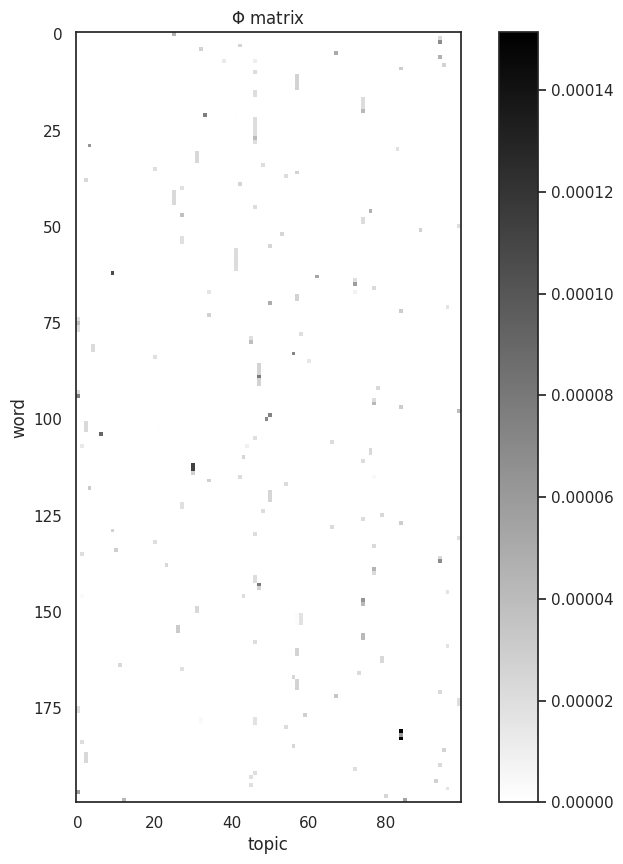

In [ ]:
plot_matrix(phi[:200,:], figsize=(10,10), xlabel='topic', ylabel='word',
            title='$\Phi$ matrix', save='PLSA_Phi.eps')